<a href="https://colab.research.google.com/github/AldanaBRZ/english2french/blob/main/english2french.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Understand the problem statement and business case

I will be creating a seq2seq model that translates English sentences to French sentences.

### 2. Import libraries and datasets

In [ ]:
!pip install nltk
!pip install gensim
!pip install spacy
!pip install plotly
!pip install jupyterthemes

In [2]:
from collections import Counter
import operator
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('punkt')
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, TimeDistributed, RepeatVector, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from sklearn.model_selection import train_test_split
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# load the data
df_english = pd.read_csv('small_vocab_en.csv', sep = '/t', names = ['english'])
df_french = pd.read_csv('small_vocab_fr.csv', sep = '/t', names = ['french'])

<ipython-input-3-fb6af57a13c8>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_english = pd.read_csv('small_vocab_en.csv', sep = '/t', names = ['english'])
<ipython-input-3-fb6af57a13c8>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_french = pd.read_csv('small_vocab_fr.csv', sep = '/t', names = ['french'])


In [4]:
# explore the data
print('The shape of df_english is: ', df_english.shape, '\n')
print('The data looks like: \n', df_english.head(), '\n')
print('The distribution of the data is: \n')
print(df_english.info())

The shape of df_english is:  (137860, 1) 

The data looks like: 
                                              english
0  new jersey is sometimes quiet during autumn , ...
1  the united states is usually chilly during jul...
2  california is usually quiet during march , and...
3  the united states is sometimes mild during jun...
4  your least liked fruit is the grape , but my l... 

The distribution of the data is: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137860 entries, 0 to 137859
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   english  137860 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB
None


In [5]:
print('The shape of df_french is: ', df_french.shape, '\n')
print('The data looks like: \n', df_french.head(), '\n')
print('The distribution of the data is: \n')
print(df_french.info())

The shape of df_french is:  (137860, 1) 

The data looks like: 
                                               french
0  new jersey est parfois calme pendant l' automn...
1  les états-unis est généralement froid en juill...
2  california est généralement calme en mars , et...
3  les états-unis est parfois légère en juin , et...
4  votre moins aimé fruit est le raisin , mais mo... 

The distribution of the data is: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137860 entries, 0 to 137859
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   french  137860 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB
None


In [6]:
# concatenating df_english and df_french along columns
df = pd.concat([df_english, df_french], axis=1)
print('The concatenated data looks like: \n', df.head())

The concatenated data looks like: 
                                              english  \
0  new jersey is sometimes quiet during autumn , ...   
1  the united states is usually chilly during jul...   
2  california is usually quiet during march , and...   
3  the united states is sometimes mild during jun...   
4  your least liked fruit is the grape , but my l...   

                                              french  
0  new jersey est parfois calme pendant l' automn...  
1  les états-unis est généralement froid en juill...  
2  california est généralement calme en mars , et...  
3  les états-unis est parfois légère en juin , et...  
4  votre moins aimé fruit est le raisin , mais mo...  


In [7]:
print('Total English records:', len(df_english))
print('Total French records:', len(df_french))

Total English records: 137860
Total French records: 137860


### 3. Data cleaning

In [8]:
# create a function to remove punctuations
def remove_punc(x):
  return re.sub('[!#?,.:";]', '', x)

In [9]:
df['french'] = df['french'].apply(remove_punc)
df['english'] = df['english'].apply(remove_punc)

In [10]:
# count how many unique french words there are
french_counter = Counter()
df['french'].str.split().apply(french_counter.update)
total_french_words = len(french_counter)
print('There are', len(french_counter), 'unique french words.')

There are 350 unique french words.


In [11]:
# count how many unique english words there are
english_counter = Counter()
df['english'].str.split().apply(english_counter.update)
total_english_words = len(english_counter)
print('There are', total_english_words, 'unique english words.')

There are 199 unique english words.


### 4. Visualize clean dataset

In [12]:
# get english and french words and counts
english_words = list(english_counter.keys())
english_counts = list(english_counter.values())

french_words = list(french_counter.keys())
french_counts = list(french_counter.values())

In [13]:
# plot barplot of english words using plotly
fig = px.bar(x = english_words, y = english_counts)
fig.show()

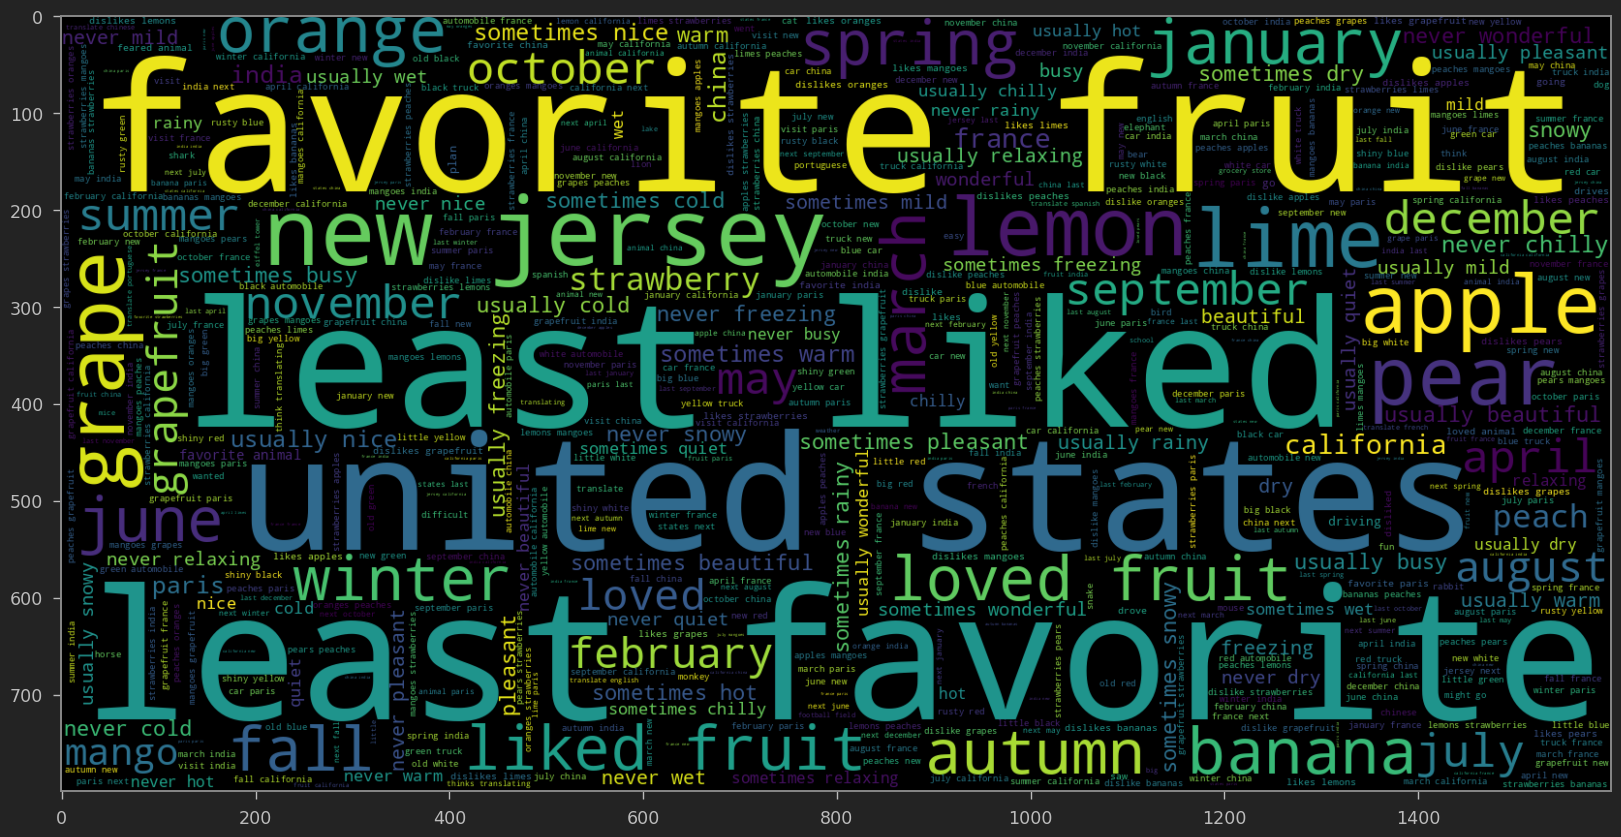

In [14]:
# plot the word cloud for english words
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 2000, width=1600, height=800).generate(" ".join(df['english']))
plt.imshow(wc, interpolation='bilinear')

In [15]:
# maximum length (number of  english words) per sentence. This will be necessary later for the embeddings
maxlen_english = -1
for sentence in df['english']:
  tokens = nltk.word_tokenize(sentence)
  if(maxlen_english < len(tokens)):
    maxlen_english = len(tokens)

print('The maximum number of words in any given sentence is', maxlen_english)

The maximum number of words in any given sentence is 15


In [16]:
# plot barplot of french words using plotly
fig = px.bar(x = french_words, y = french_counts)
fig.show()

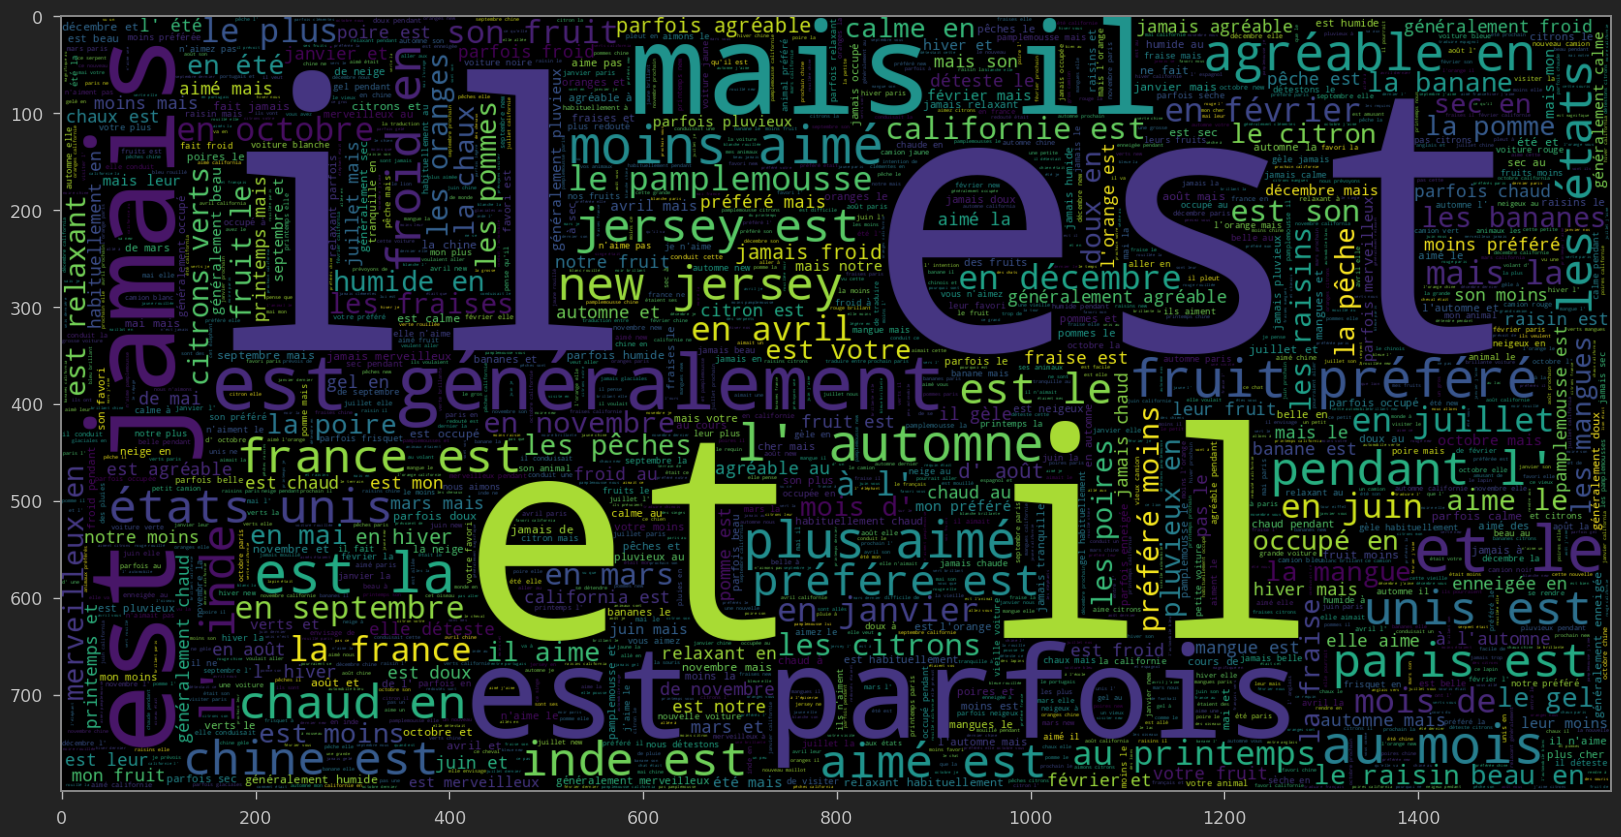

In [17]:
# plot the word cloud for french words
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 2000, width=1600, height=800).generate(" ".join(df['french']))
plt.imshow(wc, interpolation='bilinear')

In [18]:
# maximum length (number of  french words) per sentence. This will be necessary later for the embeddings
maxlen_french = -1
for sentence in df['french']:
  tokens = nltk.word_tokenize(sentence)
  if(maxlen_french < len(tokens)):
    maxlen_french = len(tokens)

print('The maximum number of words in any given sentence is', maxlen_french)

The maximum number of words in any given sentence is 23


### 5. Prepare the data by performing tokenization and padding

In [19]:
def tokenize_and_pad(x, maxlen):
  # a tokenizer to tokenize the words and create sequences of tokenized words
  tokenizer = Tokenizer(char_level = False)
  tokenizer.fit_on_texts(x)
  sequences = tokenizer.texts_to_sequences(x)
  padded = pad_sequences(sequences, maxlen = maxlen, padding = 'post')

  return tokenizer, sequences, padded

In [20]:
# tokenize and pad the data
x_tokenizer, x_sequences, x_padded = tokenize_and_pad(df['english'], maxlen_english)
y_tokenizer, y_sequences, y_padded = tokenize_and_pad(df['french'], maxlen_french)

In [21]:
print('The tokenized version of the sentence\n', df['english'][-1:].item(), '\n is: ', x_padded[-1:])

The tokenized version of the sentence
 the orange is her favorite fruit  but the banana is your favorite  
 is:  [[ 5 84  1 32 11 13  6  5 87  1 29 11  0  0  0]]


In [22]:
print('The tokenized version of the sentence\n', df['english'][-1:].item(), '\n is: ', x_padded[-1:])

The tokenized version of the sentence
 the orange is her favorite fruit  but the banana is your favorite  
 is:  [[ 5 84  1 32 11 13  6  5 87  1 29 11  0  0  0]]


In [23]:
# split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_padded, y_padded, test_size = 0.1)

### 6. Build and train the LSTM network

In [24]:
# total vocab size, since we added padding we add 1 to the total word count
english_vocab_size = total_english_words + 1
french_vocab_size = total_french_words + 1

# sequential model
model = Sequential()
# embedding layer
model.add(Embedding(english_vocab_size, 256, input_length = maxlen_english, mask_zero = True))
# encoder
model.add(LSTM(256))
# decoder
# repeat vector repeats the input for a desired number of times to change 2D-array to 3D array
model.add(RepeatVector(maxlen_french))
model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax')))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 256)           51200     
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 repeat_vector (RepeatVector  (None, 23, 256)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 23, 256)           525312    
                                                                 
 time_distributed (TimeDistr  (None, 23, 351)          90207     
 ibuted)                                                         
                                                                 
Total params: 1,192,031
Trainable params: 1,192,031
Non-

In [25]:
y_train = np.expand_dims(y_train, axis=2)
y_train.shape

(124074, 23, 1)

In [26]:
model.fit(x_train, y_train, batch_size=1024, validation_split=0.1, epochs=15)

Epoch 1/15
110/110 [==============================] - 315s 3s/step - loss: 2.6992 - accuracy: 0.4980 - val_loss: 2.1108 - val_accuracy: 0.5453
Epoch 2/15
110/110 [==============================] - 286s 3s/step - loss: 1.8664 - accuracy: 0.5692 - val_loss: 1.6301 - val_accuracy: 0.5939
Epoch 3/15
110/110 [==============================] - 255s 2s/step - loss: 1.5394 - accuracy: 0.6058 - val_loss: 1.4199 - val_accuracy: 0.6266
Epoch 4/15
110/110 [==============================] - 253s 2s/step - loss: 1.3301 - accuracy: 0.6414 - val_loss: 1.2495 - val_accuracy: 0.6529
Epoch 5/15
110/110 [==============================] - 253s 2s/step - loss: 1.1801 - accuracy: 0.6666 - val_loss: 1.1626 - val_accuracy: 0.6686
Epoch 6/15
110/110 [==============================] - 254s 2s/step - loss: 1.0482 - accuracy: 0.6990 - val_loss: 1.0307 - val_accuracy: 0.7008
Epoch 7/15
110/110 [==============================] - 253s 2s/step - loss: 0.9291 - accuracy: 0.7328 - val_loss: 0.8776 - val_accuracy: 0.7498

In [28]:
# save the model
model.save('weights.h5')

### 9. Assess model performance

In [38]:
def prediction(x, x_tokenizer = x_tokenizer, y_tokenizer = y_tokenizer):
  prediction = model.predict(x)[0]
  id_to_word = {id: word for word, id in y_tokenizer.word_index.items()}
  id_to_word[0] = ''

  return ' '.join([id_to_word[j] for j in np.argmax(prediction, 1)])

In [40]:
def pad_to_text(padded, tokenizer):
  id_to_word = {id: word for word, id in tokenizer.word_index.items()}
  id_to_word[0] = ''

  return ' '.join([id_to_word[j] for j in padded])

In [41]:
for i in range(5):
  print('Original english word - {}\n'.format(pad_to_text(x_test[i], x_tokenizer)))
  print('Original french word - {}\n'.format(pad_to_text(y_test[i], y_tokenizer)))
  print('Predicted french word - {}\n\n\n\n'.format(prediction(x_test[i:i+1])))

Original english word - the united states is dry during january and it is mild in summer  

Original french word - les états unis est sec en janvier et il est doux en été          

1/1 [==============================] - 0s 24ms/step
Predicted french word - les états unis est froid en janvier et il est chaud en été          




Original english word - you like pears limes and bananas         

Original french word - vous aimez les poires les citrons verts et les bananes             

1/1 [==============================] - 0s 24ms/step
Predicted french word - vous aimez les citrons les verts et les bananes              




Original english word - china is sometimes freezing during december and it is sometimes busy in november  

Original french word - chine est parfois le gel en décembre et il est parfois occupé en novembre         

1/1 [==============================] - 0s 26ms/step
Predicted french word - la californie est le gel gel décembre décembre et est parfois parfois en nove